In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, fontManager
import pandas as pd
import folium

In [14]:
# List of places with GPS coordinates
places = [
    (28.7400646, -13.8693225, "Corralejo"),
    (28.6827004, -14.0101076, "El Cotillo"),
    (28.6802009, -13.9340479, "Lajares"),
    (28.7501766, -13.8217035, "Isla de Lobos")
]

# Define color palette pairs
color_palette_actual = [
    ('#f4f1de', '#e07a5f'), 
    ('#ff0f7b', '#f89b29'),  
    ('#60efff', '#0061ff')   
]

# Extend with additional colors if necessary
additional_colors = [
    ('#45caff', '#ff1b6b'),  
    ('#f8acff', '#696eff'),  
    ('#9bafd9', '#103783'),  
    ('#95f9c3', '#0b3866'),  
    ('#613232', '#ffc8c8'),  
    ('#f4f1de', '#e07a5f'),  
    ('#6ff7e8', '#1f7ea1'),  
    ('#00f59b', '#7014f2'), 
    ('#07f49e', '#42047e'),  
    ('#faf0ca', '#0d3b66')   
]

# Combine the colors to make 12 pairs
color_palette_actual.extend(additional_colors[:len(places) - len(color_palette_actual)])

In [15]:
# Check available fonts
available_fonts = sorted([f.name for f in fontManager.ttflist])
print("Available fonts: ", available_fonts)

# Set the font properties (use a different font if Nanum Gothic is not available)
font_properties_city = FontProperties(family='.aqua kana', size=30)  # Font for city name
font_properties_country = FontProperties(family='.aqua kana', size=20)  # Font for country name

Available fonts:  ['.Aqua Kana', '.Keyboard', '.New York', '.New York', '.SF Arabic', '.SF Arabic Rounded', '.SF Armenian', '.SF Armenian Rounded', '.SF Camera', '.SF Compact', '.SF Compact', '.SF Compact Rounded', '.SF Georgian', '.SF Georgian Rounded', '.SF Hebrew', '.SF Hebrew Rounded', '.SF NS Mono', '.SF NS Mono', '.SF NS Rounded', '.SF Soft Numeric', '.ThonburiUI', 'Abolition', 'Academy Engraved LET', 'Al Bayan', 'Al Nile', 'Al Tarikh', 'Alegreya', 'Alegreya', 'Alegreya', 'American Typewriter', 'Andale Mono', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Chancery', 'Apple SD Gothic Neo', 'Apple Symbols', 'AppleGothic', 'AppleMyungjo', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial Black', 'Arial Hebrew', 'Arial Narrow', 'Arial Narrow', 'Arial Narrow', 'Arial Narrow', 'Arial Rounded MT Bold', 'Arial Unicode MS', 'Arial Unicode MS', 'Athelas', 'Avenir', 'Avenir Next', 'Avenir Next Condensed', 'Ayuthaya', 'Baghdad', 'Bangla MN', 'Bangla Sang

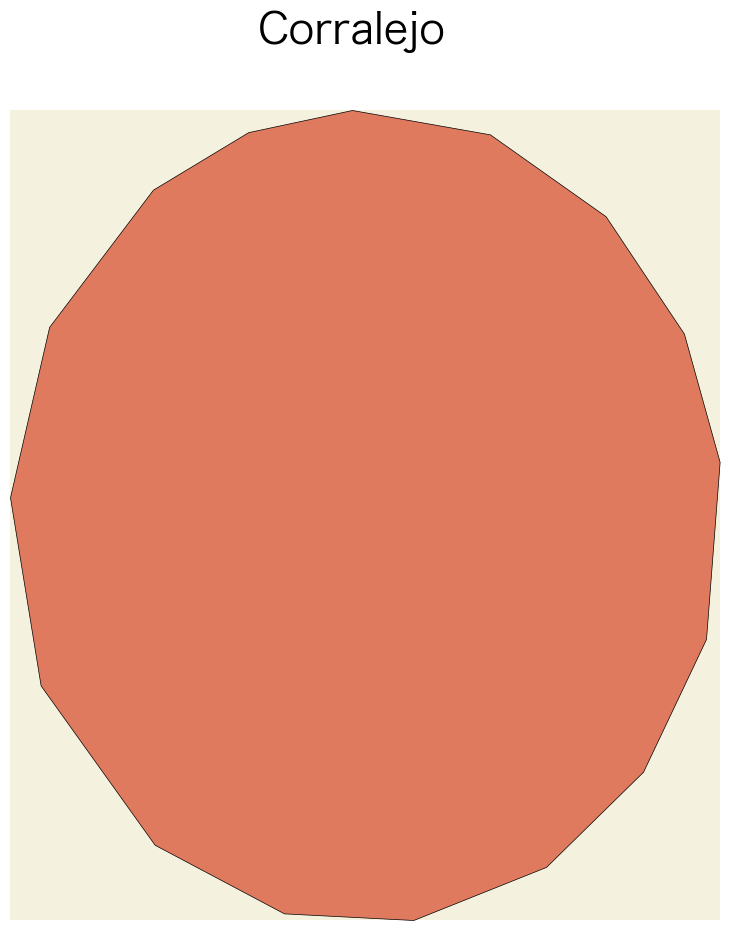

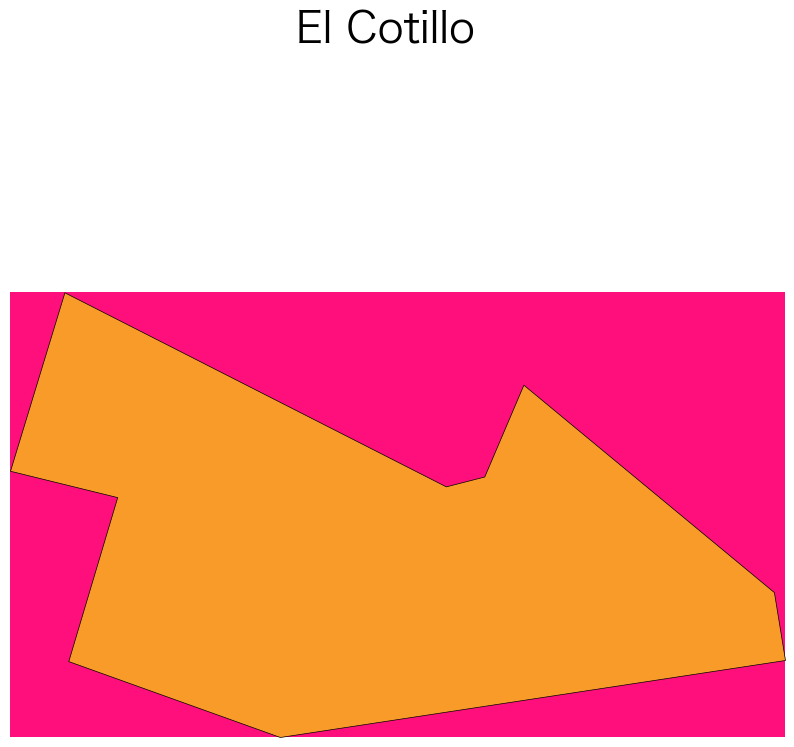

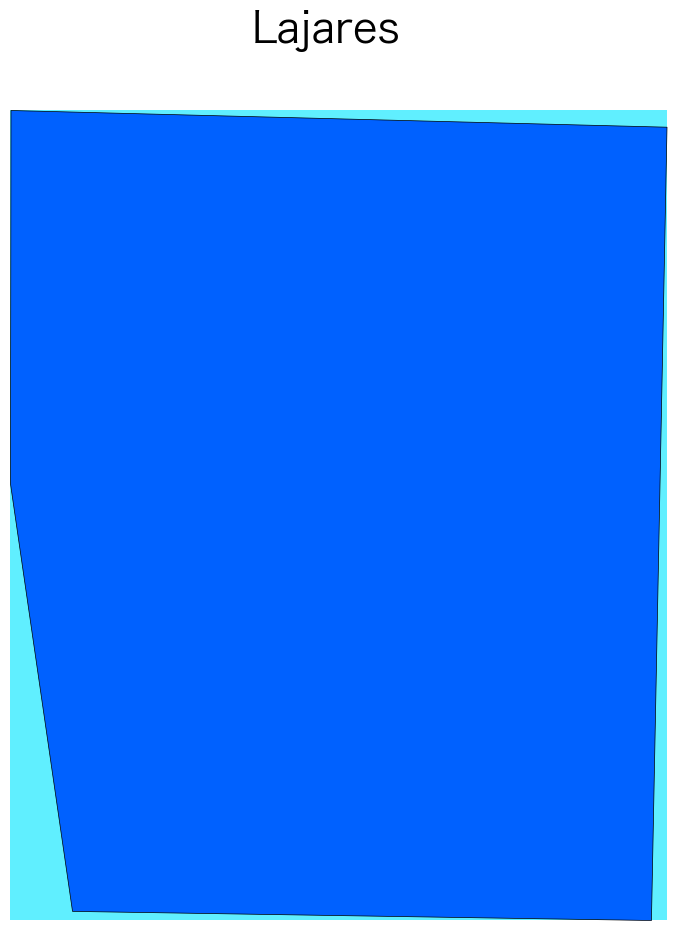

TypeError: Nominatim did not geocode query '28.7501766, -13.8217035' to a geometry of type (Multi)Polygon.. Skipping Isla de Lobos.


In [ ]:
for i, (lat, lon, place_name) in enumerate(places):
    # Use the `geocode_to_gdf` function to get the geometries of the area
    tags = {'place': ['city', 'town', 'village']}
    try:
        gdf = ox.geocode_to_gdf(place_name)
        gdf = gdf.to_crs(epsg=3857)  # Ensure correct projection for plotting
    except TypeError as e:
        print(f"TypeError: {e}. Skipping {place_name}.")
        continue

    # Download the street network data for the place with a wider angle (zoom level 13)
    try:
        graph = ox.graph_from_place(place_name, network_type='drive', simplify=True)
        graph = ox.project_graph(graph, to_crs='epsg:3857')
    except Exception as e:
        print(f"Error fetching graph for {place_name}: {e}. Skipping.")
        continue

    # Select a color pair (cycling through the list)
    background_color, edge_color = color_palette_actual[i % len(color_palette_actual)]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.subplots_adjust(top=0.92)  # Adjust to create space at the top

    # Plot the geometries on the axis with the background color
    ax.set_facecolor(background_color)
    gdf.plot(ax=ax, facecolor=edge_color, edgecolor='k', linewidth=0.5)

    # Plot the street network on the same axis
    ox.plot_graph(graph, ax=ax, node_size=0, edge_color='black', edge_linewidth=1.5, show=False, close=False)

    # Add the place name above the visualization
    fig.suptitle(place_name, fontsize=30, fontproperties=font_properties_city, color='black', ha='center', y=1.02)

    # Load your GPS data from CSV (replace with the correct path)
    csv_path = 'Fuerteventura2025_cleaned_info.csv'
    try:
        df = pd.read_csv(csv_path)
        df_cleaned = df.dropna(subset=['lat', 'lon'])
        df_cleaned = df_cleaned.to_crs(epsg=3857)
    except FileNotFoundError:
        print(f"CSV file not found: {csv_path}. Skipping GPS points.")
        continue

    # Overlay GPS points on the map
    for _, row in df_cleaned.iterrows():
        x, y = row['geometry'].x, row['geometry'].y
        ax.plot(x, y, marker='o', color='red', markersize=5)

    # Set the axis limits to the bounds of the GeoDataFrame
    west, south, east, north = gdf.geometry.union_all().bounds
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)

    # Save the plot to a file with the place name
    filename = f'urban_area_{place_name.replace(" ", "_")}_combined.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
from shapely.geometry import Point

# Assuming df_cleaned has 'lat' and 'lon' columns
df_cleaned['geometry'] = df_cleaned.apply(lambda row: Point(row['lon'], row['lat']), axis=1)